In [1]:
import numpy as np
import pandas as pd
import gc
import time
from contextlib import contextmanager
import lightgbm as lgb
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [ ]:
df=pd.read_csv('df_500.csv')

In [2]:
df=pd.read_csv('df_1634.csv')

/home/chenyang.shi/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (848) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [2]:
df=pd.read_csv('df_1000.csv')

In [3]:
df

,index,AMT_ANNUITY,AMT_CREDIT,AMT_GOODS_PRICE,AMT_INCOME_TOTAL,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_WEEK,...,SK_ID_CURR_sum_RATE_DOWN_PAYMENT_TOP730,SK_ID_CURR_var_AMT_ANNUITY_TOP730_y,SK_ID_CURR_var_AMT_APPLICATION_TOP730,SK_ID_CURR_var_AMT_CREDIT_TOP730,SK_ID_CURR_var_AMT_DOWN_PAYMENT_TOP730,SK_ID_CURR_var_AMT_GOODS_PRICE_TOP730,SK_ID_CURR_var_CNT_PAYMENT_TOP730,SK_ID_CURR_var_DAYS_DECISION_TOP730,SK_ID_CURR_var_HOUR_APPR_PROCESS_START_TOP730,SK_ID_CURR_var_RATE_DOWN_PAYMENT_TOP730
0,0,24700.5,406597.5,351000.0,202500.000,0.0,0.0,0.0,0.0,0.0,...,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,35698.5,1293502.5,1129500.0,270000.000,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,6750.0,135000.0,135000.0,67500.000,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,29686.5,312682.5,297000.0,135000.000,NaN,NaN,NaN,NaN,NaN,...,0.326824,1.856019e+08,8.189620e+10,1.111138e+11,2.066837e+09,6.434877e+10,409.200000,24723.277778,1.000000,0.005923
4,4,21865.5,513000.0,513000.0,121500.000,0.0,0.0,0.0,0.0,0.0,...,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,5,27517.5,490495.5,454500.0,99000.000,0.0,0.0,0.0,1.0,0.0,...,0.000000,2.755596e+07,5.192298e+10,6.559893e+10,NaN,4.129981e+10,200.000000,77592.333333,21.333333,NaN
6,6,41301.0,1560726.0,1395000.0,171000.000,0.0,0.0,1.0,1.0,0.0,...,0.358798,1.425047e+06,9.574438e+08,9.161002e+08,3.717472e+07,9.574438e+08,9.000000,24114.000000,10.916667,0.004101
7,7,42075.0,1530000.0,1530000.0,360000.000,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,8,33826.5,1019610.0,913500.0,112500.000,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,9,20250.0,405000.0,405000.0,135000.000,NaN,NaN,NaN,NaN,NaN,...,0.000000,NaN,4.050000e+09,6.529159e+09,NaN,NaN,NaN,80000.000000,2.000000,NaN


In [3]:
USELESS_COLUMNS = ['FLAG_DOCUMENT_10',
                   'FLAG_DOCUMENT_12',
                   'FLAG_DOCUMENT_13',
                   'FLAG_DOCUMENT_14',
                   'FLAG_DOCUMENT_15',
                   'FLAG_DOCUMENT_16',
                   'FLAG_DOCUMENT_17',
                   'FLAG_DOCUMENT_19',
                   'FLAG_DOCUMENT_2',
                   'FLAG_DOCUMENT_20',
                   'FLAG_DOCUMENT_21']

In [4]:
df.shape

(356255, 1022)

In [5]:
df.columns

Index(['index', 'AMT_ANNUITY', 'AMT_CREDIT', 'AMT_GOODS_PRICE',
       'AMT_INCOME_TOTAL', 'AMT_REQ_CREDIT_BUREAU_DAY',
       'AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_MON',
       'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_WEEK',
       ...
       'previous_application_prev_was_refused',
       'previous_application_term_of_last_1_credits_mean',
       'previous_application_days_decision_about_last_1_credits_mean',
       'previous_application_days_first_drawing_last_1_credits_mean',
       'previous_application_term_of_last_3_credits_mean',
       'previous_application_days_decision_about_last_3_credits_mean',
       'previous_application_days_first_drawing_last_3_credits_mean',
       'previous_application_term_of_last_5_credits_mean',
       'previous_application_days_decision_about_last_5_credits_mean',
       'previous_application_days_first_drawing_last_5_credits_mean'],
      dtype='object', length=1022)

In [6]:
df

,index,AMT_ANNUITY,AMT_CREDIT,AMT_GOODS_PRICE,AMT_INCOME_TOTAL,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_WEEK,...,previous_application_prev_was_refused,previous_application_term_of_last_1_credits_mean,previous_application_days_decision_about_last_1_credits_mean,previous_application_days_first_drawing_last_1_credits_mean,previous_application_term_of_last_3_credits_mean,previous_application_days_decision_about_last_3_credits_mean,previous_application_days_first_drawing_last_3_credits_mean,previous_application_term_of_last_5_credits_mean,previous_application_days_decision_about_last_5_credits_mean,previous_application_days_first_drawing_last_5_credits_mean
0,0,24700.5,406597.5,351000.0,202500.000,0.0,0.0,0.0,0.0,0.0,...,0.0,24.0,-606.0,NaN,24.000000,-606.000000,NaN,24.000000,-606.000000,NaN
1,1,35698.5,1293502.5,1129500.0,270000.000,0.0,0.0,0.0,0.0,0.0,...,0.0,12.0,-746.0,NaN,10.000000,-1305.000000,NaN,10.000000,-1305.000000,NaN
2,2,6750.0,135000.0,135000.0,67500.000,0.0,0.0,0.0,0.0,0.0,...,0.0,4.0,-815.0,NaN,4.000000,-815.000000,NaN,4.000000,-815.000000,NaN
3,3,29686.5,312682.5,297000.0,135000.000,NaN,NaN,NaN,NaN,NaN,...,1.0,48.0,-181.0,NaN,48.000000,-181.000000,NaN,24.000000,-181.000000,NaN
4,4,21865.5,513000.0,513000.0,121500.000,0.0,0.0,0.0,0.0,0.0,...,0.0,24.0,-374.0,NaN,30.000000,-702.000000,NaN,22.800000,-996.000000,NaN
5,5,27517.5,490495.5,454500.0,99000.000,0.0,0.0,0.0,1.0,0.0,...,0.0,NaN,-82.0,NaN,20.000000,-363.666667,NaN,14.000000,-1192.000000,NaN
6,6,41301.0,1560726.0,1395000.0,171000.000,0.0,0.0,1.0,1.0,0.0,...,0.0,10.0,-74.0,NaN,7.333333,-229.000000,NaN,8.000000,-392.400000,NaN
7,7,42075.0,1530000.0,1530000.0,360000.000,0.0,0.0,0.0,0.0,0.0,...,0.0,10.0,-1070.0,NaN,10.000000,-1070.000000,NaN,10.000000,-1070.000000,NaN
8,8,33826.5,1019610.0,913500.0,112500.000,0.0,0.0,0.0,0.0,0.0,...,1.0,NaN,-1162.0,NaN,15.000000,-1543.333333,-2277.0,14.000000,-1784.500000,-2277.0
9,9,20250.0,405000.0,405000.0,135000.000,NaN,NaN,NaN,NaN,NaN,...,0.0,NaN,-107.0,NaN,21.000000,-482.000000,NaN,18.000000,-779.750000,NaN


In [7]:
for bin_feature in [ 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
    df[bin_feature], uniques = pd.factorize(df[bin_feature])

In [8]:
set(df['FLAG_OWN_CAR'])

{0, 1}

In [9]:
set(df['FLAG_OWN_REALTY'])

{0, 1}

In [10]:
df.shape

(356255, 1022)

In [11]:
def one_hot_encoder(df, nan_as_category = True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

In [12]:
df, cat_cols = one_hot_encoder(df, nan_as_category=False)

In [13]:
df.shape

(356255, 1141)

In [14]:
df= df.drop(USELESS_COLUMNS,axis=1)

In [15]:
df.shape

(356255, 1130)

In [16]:
import xgboost as xgb
from xgboost import plot_importance

In [17]:
train_df = df[df['TARGET'].notnull()]
test_df = df[df['TARGET'].isnull()]
del df
gc.collect()

14

In [ ]:
print("Starting XGBOOST. Train shape: {}, test shape: {}".format(train_df.shape, test_df.shape))
folds = KFold(n_splits= 5, shuffle=True, random_state=1001)
    # Create arrays and dataframes to store results
oof_preds = np.zeros(train_df.shape[0])
sub_preds = np.zeros(test_df.shape[0])
feature_importance_df = pd.DataFrame()

out_folder_train_prediction= pd.DataFrame()
out_folder_test_prediction= pd.DataFrame()

feats = [f for f in train_df.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
dtest=xgb.DMatrix(test_df[feats])
    
for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df['TARGET'])):
    dtrain = xgb.DMatrix(train_df[feats].iloc[train_idx],train_df['TARGET'].iloc[train_idx])
    dvalid = xgb.DMatrix(train_df[feats].iloc[valid_idx], train_df['TARGET'].iloc[valid_idx])
    valid_y=train_df['TARGET'].iloc[valid_idx]

       # xgb
    params = {'eval_metric': 'auc',
              'objective': 'binary:logistic',
              'booster':'gbtree',
              'tree_method': 'hist',
              'nthread' : 4,
              'eta' : 0.01,
                'max_leaves': 50,
              'max_depth' : 13,
              'max_bin': 297,
              'min_child_weight' : 9.7846,
              'subsample' : 0.7896,
              'colsample_bytree' : 0.6418,
              'colsample_bylevel' : 1,
              'alpha' : 0.0025,
              'lambda' : 0.0025,
              'scale_pos_weight': 1}
    watchlist = [(dtrain, 'train'), (dvalid, 'valid')]
        
    model=xgb.train(params, dtrain, 5000, watchlist, maximize=True, early_stopping_rounds = 100, verbose_eval=100)
    
    train_preds=pd.DataFrame()
    train_preds['train_pred'] = model.predict(dvalid, ntree_limit=model.best_ntree_limit)
    train_preds['TARGET']=train_df['TARGET'].iloc[valid_idx]
    train_preds["folder"]=n_fold + 1
    out_folder_train_prediction = pd.concat([out_folder_train_prediction, oof_preds], axis=0)
    
    test_preds=pd.DataFrame()
    test_preds['test_pred']= model.predict(dtest,ntree_limit=model.best_ntree_limit)
    test_preds["folder"]=n_fold + 1
    out_folder_test_prediction = pd.concat([out_folder_test_prediction, test_preds], axis=0)
    
    
    oof_preds[valid_idx] = model.predict(dvalid, ntree_limit=model.best_ntree_limit)
    sub_preds += model.predict(dtest,ntree_limit=model.best_ntree_limit) / folds.n_splits

    fold_importance_df = pd.DataFrame()
    fold_importance_df = pd.DataFrame(model.get_fscore().items(), columns=['feature','importance']).sort_values('importance', ascending=False)
    fold_importance_df["fold"] = n_fold + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(valid_y, oof_preds[valid_idx])))
    del model, dtrain, dvalid, valid_y
    gc.collect()

out_folder_train_prediction.to_csv('out_folder_train_prediction_xgb_1634.csv',index= False)
out_folder_test_prediction.to_csv('out_folder_test_prediction_xgb_1634.csv',index= False)

print('Full AUC score %.6f' % roc_auc_score(train_df['TARGET'], oof_preds))
    # Write submission file and plot feature importance
test_df['TARGET'] = sub_preds
test_df[['SK_ID_CURR', 'TARGET']].to_csv('xgb_1634feature.csv', index= False)

In [ ]:
cols = feature_importance_df[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:40].index
best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]
plt.figure(figsize=(8, 10))
sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
plt.title('XGB Features (avg over folds)')
plt.tight_layout
plt.show()

In [ ]:
feature_importance_df.to_csv('feature_importance_xgb1634features.csv', index=False)

In [19]:
# xgboost: 0.79, change the tunining parameter to your result
folds = KFold(n_splits= 5, shuffle=True, random_state=1001)
    # Create arrays and dataframes to store results
out_folder_train_prediction= pd.DataFrame()
out_folder_test_prediction= pd.DataFrame()


feats = [f for f in train_df.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
dtest=xgb.DMatrix(test_df[feats])
    
for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df['TARGET'])):
    dtrain = xgb.DMatrix(train_df[feats].iloc[train_idx],train_df['TARGET'].iloc[train_idx])
    dvalid = xgb.DMatrix(train_df[feats].iloc[valid_idx], train_df['TARGET'].iloc[valid_idx])
    valid_y=train_df['TARGET'].iloc[valid_idx]

       # xgb
    params = {'eval_metric': 'auc',
              'objective': 'binary:logistic',
              'booster':'gbtree',
              'tree_method': 'hist',
              'nthread' : 4,
              'eta' : 0.01,
                'max_leaves': 50,
              'max_depth' : 13,
              'max_bin': 297,
              'min_child_weight' : 9.7846,
              'subsample' : 0.7896,
              'colsample_bytree' : 0.6418,
              'colsample_bylevel' : 1,
              'alpha' : 0.0025,
              'lambda' : 0.0025,
              'scale_pos_weight': 1}
    watchlist = [(dtrain, 'train'), (dvalid, 'valid')]
        
    model=xgb.train(params, dtrain, 5000, watchlist, maximize=True, early_stopping_rounds = 100, verbose_eval=100)
    oof_preds=pd.DataFrame()
    oof_preds['train_pred'] = model.predict(dvalid, ntree_limit=model.best_ntree_limit)
    oof_preds['TARGET']=train_df['TARGET'].iloc[valid_idx]
    oof_preds["folder"]=n_fold + 1
    out_folder_train_prediction = pd.concat([out_folder_train_prediction, oof_preds], axis=0)
    test_preds=pd.DataFrame()
    test_preds['test_pred']= model.predict(dtest,ntree_limit=model.best_ntree_limit)
    test_preds["folder"]=n_fold + 1
    out_folder_test_prediction = pd.concat([out_folder_test_prediction, test_preds], axis=0)
    del model, dtrain, dvalid, valid_y
    gc.collect()
    
out_folder_train_prediction.to_csv('out_folder_train_prediction_xgb.csv',index= False)
out_folder_test_prediction.to_csv('out_folder_test_prediction_xgb.csv',index= False)

[0]	train-auc:0.728399	valid-auc:0.717591
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 100 rounds.
[100]	train-auc:0.761799	valid-auc:0.751572
[200]	train-auc:0.770968	valid-auc:0.756517
[300]	train-auc:0.78142	valid-auc:0.761979
[400]	train-auc:0.792881	valid-auc:0.768108
[500]	train-auc:0.80369	valid-auc:0.773646
[600]	train-auc:0.812978	valid-auc:0.777856
[700]	train-auc:0.821243	valid-auc:0.781107
[800]	train-auc:0.828578	valid-auc:0.783606
[900]	train-auc:0.835307	valid-auc:0.785481
[1000]	train-auc:0.841669	valid-auc:0.786952
[1100]	train-auc:0.847527	valid-auc:0.788089
[1200]	train-auc:0.853375	valid-auc:0.788949
[1300]	train-auc:0.858827	valid-auc:0.789651
[1400]	train-auc:0.864012	valid-auc:0.790359
[1500]	train-auc:0.869079	valid-auc:0.790999
[1600]	train-auc:0.873845	valid-auc:0.791491
[1700]	train-auc:0.87837	valid-auc:0.791979
[1800]	train-auc:0.882659	valid-auc:0.792253
[1900]	train-auc

In [20]:
df1= pd.read_csv('out_folder_train_prediction_xgb.csv')
df1

,train_pred,TARGET,folder
0,0.035678,NaN,1
1,0.042576,NaN,1
2,0.057968,0.0,1
3,0.055486,0.0,1
4,0.006375,NaN,1
5,0.027167,0.0,1
6,0.082319,NaN,1
7,0.028539,NaN,1
8,0.016324,0.0,1
9,0.019718,NaN,1


In [ ]:
######################################
################  First ##############
######################################

In [18]:
print("Starting XGBOOST. Train shape: {}, test shape: {}".format(train_df.shape, test_df.shape))
folds = KFold(n_splits= 5, shuffle=True, random_state=1001)
    # Create arrays and dataframes to store results
oof_preds = np.zeros(train_df.shape[0])
sub_preds = np.zeros(test_df.shape[0])
feature_importance_df = pd.DataFrame()

feats = [f for f in train_df.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
dtest=xgb.DMatrix(test_df[feats])
    
for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df['TARGET'])):
    dtrain = xgb.DMatrix(train_df[feats].iloc[train_idx],train_df['TARGET'].iloc[train_idx])
    dvalid = xgb.DMatrix(train_df[feats].iloc[valid_idx], train_df['TARGET'].iloc[valid_idx])
    valid_y=train_df['TARGET'].iloc[valid_idx]

       # xgb
    params = {'eval_metric': 'auc',
              'objective': 'binary:logistic',
              'booster':'gbtree',
              'tree_method': 'auto',
              'nthread' : 4,
              'eta' : 0.02,
               'max_leaves': 40,
              'max_depth' : 16,
              'max_bin': 255,
              'min_child_weight' : 4,
              'subsample' : 0.5,
              'colsample_bytree' : 0.5,
              'colsample_bylevel' : 1,
              'alpha' : 0.001,
              'lambda' : 0.001,
              'scale_pos_weight': 1}
    watchlist = [(dtrain, 'train'), (dvalid, 'valid')]
        
    model=xgb.train(params, dtrain, 5000, watchlist, maximize=True, early_stopping_rounds = 100, verbose_eval=100)
    oof_preds[valid_idx] = model.predict(dvalid, ntree_limit=model.best_ntree_limit)
    sub_preds += model.predict(dtest,ntree_limit=model.best_ntree_limit) / folds.n_splits

    fold_importance_df = pd.DataFrame()
    fold_importance_df = pd.DataFrame(model.get_fscore().items(), columns=['feature','importance']).sort_values('importance', ascending=False)
    fold_importance_df["fold"] = n_fold + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(valid_y, oof_preds[valid_idx])))
    del model, dtrain, dvalid, valid_y

print('Full AUC score %.6f' % roc_auc_score(train_df['TARGET'], oof_preds))
    # Write submission file and plot feature importance
test_df['TARGET'] = sub_preds
test_df[['SK_ID_CURR', 'TARGET']].to_csv('xgb_1030feature02.csv', index= False)

Starting XGBOOST. Train shape: (307511, 1130), test shape: (48744, 1130)
[0]	train-auc:0.741699	valid-auc:0.60662
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 100 rounds.
[100]	train-auc:0.957403	valid-auc:0.766328
[200]	train-auc:0.985187	valid-auc:0.775544
[300]	train-auc:0.995554	valid-auc:0.782228
[400]	train-auc:0.998713	valid-auc:0.785117
[500]	train-auc:0.999595	valid-auc:0.785828
[600]	train-auc:0.999884	valid-auc:0.786258
[700]	train-auc:0.999972	valid-auc:0.786419
Stopping. Best iteration:
[667]	train-auc:0.999954	valid-auc:0.786504

Fold  1 AUC : 0.786504
[0]	train-auc:0.747685	valid-auc:0.600049
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 100 rounds.
[100]	train-auc:0.958099	valid-auc:0.766262
[200]	train-auc:0.985126	valid-auc:0.775481
[300]	train-auc:0.995375	valid-auc:0.78213
[400]	train-auc:0.99868

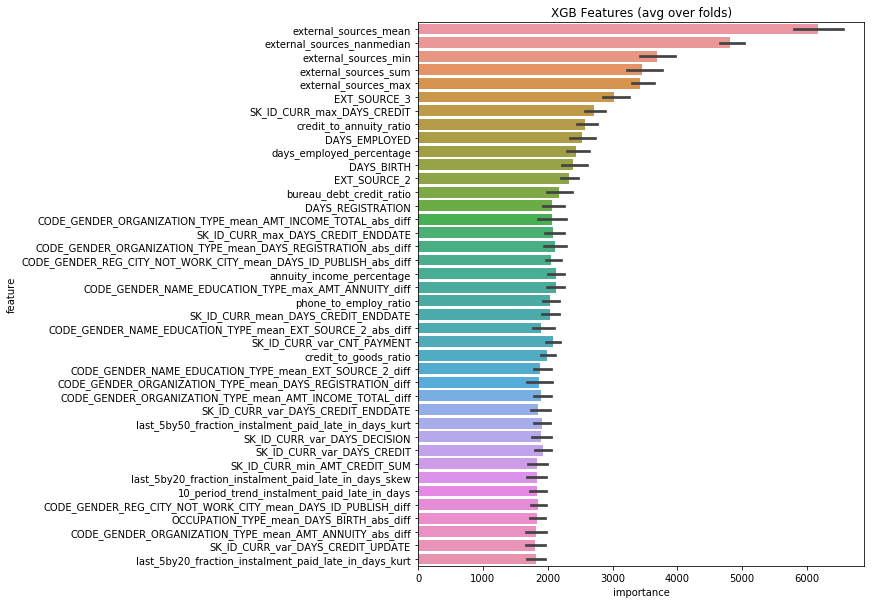

In [19]:
cols = feature_importance_df[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:40].index
best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]
plt.figure(figsize=(8, 10))
sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
plt.title('XGB Features (avg over folds)')
plt.tight_layout
plt.show()

In [20]:
feature_importance_df.to_csv('feature_importance_xgb1030features02.csv', index=False)

In [15]:
######################################
################  Again ##############
######################################

In [17]:
print("Starting XGBOOST. Train shape: {}, test shape: {}".format(train_df.shape, test_df.shape))
folds = KFold(n_splits= 5, shuffle=True, random_state=1001)
    # Create arrays and dataframes to store results
oof_preds = np.zeros(train_df.shape[0])
sub_preds = np.zeros(test_df.shape[0])
feature_importance_df = pd.DataFrame()

feats = [f for f in train_df.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
dtest=xgb.DMatrix(test_df[feats])
    
for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df['TARGET'])):
    dtrain = xgb.DMatrix(train_df[feats].iloc[train_idx],train_df['TARGET'].iloc[train_idx])
    dvalid = xgb.DMatrix(train_df[feats].iloc[valid_idx], train_df['TARGET'].iloc[valid_idx])
    valid_y=train_df['TARGET'].iloc[valid_idx]

       # xgb
    params = {'eval_metric': 'auc',
              'objective': 'binary:logistic',
              'booster':'gbtree',
              'tree_method': 'auto',
              'nthread' : 4,
              'eta' : 0.01,
                'max_leaves': 50,
              'max_depth' : 15.2720,
              'max_bin': 297,
              'min_child_weight' : 1,
              'subsample' : 0.5,
              'colsample_bytree' : 0.5,
              'colsample_bylevel' : 1,
              'alpha' : 0,
              'lambda' :  6.1936,
              'scale_pos_weight': 6.0546}
    watchlist = [(dtrain, 'train'), (dvalid, 'valid')]
        
    model=xgb.train(params, dtrain, 5000, watchlist, maximize=True, early_stopping_rounds = 100, verbose_eval=100)
    oof_preds[valid_idx] = model.predict(dvalid, ntree_limit=model.best_ntree_limit)
    sub_preds += model.predict(dtest,ntree_limit=model.best_ntree_limit) / folds.n_splits

    fold_importance_df = pd.DataFrame()
    fold_importance_df = pd.DataFrame(model.get_fscore().items(), columns=['feature','importance']).sort_values('importance', ascending=False)
    fold_importance_df["fold"] = n_fold + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(valid_y, oof_preds[valid_idx])))
    del model, dtrain, dvalid, valid_y

print('Full AUC score %.6f' % roc_auc_score(train_df['TARGET'], oof_preds))
    # Write submission file and plot feature importance
test_df['TARGET'] = sub_preds
test_df[['SK_ID_CURR', 'TARGET']].to_csv('xgb_1030feature03.csv', index= False)

Starting XGBOOST. Train shape: (307511, 1130), test shape: (48744, 1130)
[0]	train-auc:0.790524	valid-auc:0.653495
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 100 rounds.
[100]	train-auc:0.979415	valid-auc:0.769872
[200]	train-auc:0.99127	valid-auc:0.774628
[300]	train-auc:0.996341	valid-auc:0.777488
[400]	train-auc:0.998457	valid-auc:0.779996
[500]	train-auc:0.999397	valid-auc:0.780872
[600]	train-auc:0.99978	valid-auc:0.781028
[700]	train-auc:0.999926	valid-auc:0.781242
Stopping. Best iteration:
[678]	train-auc:0.999907	valid-auc:0.781319

Fold  1 AUC : 0.781319
[0]	train-auc:0.7877	valid-auc:0.649845
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 100 rounds.
[100]	train-auc:0.978913	valid-auc:0.768354
[200]	train-auc:0.991011	valid-auc:0.773799
[300]	train-auc:0.996198	valid-auc:0.777569
[400]	train-auc:0.998375	

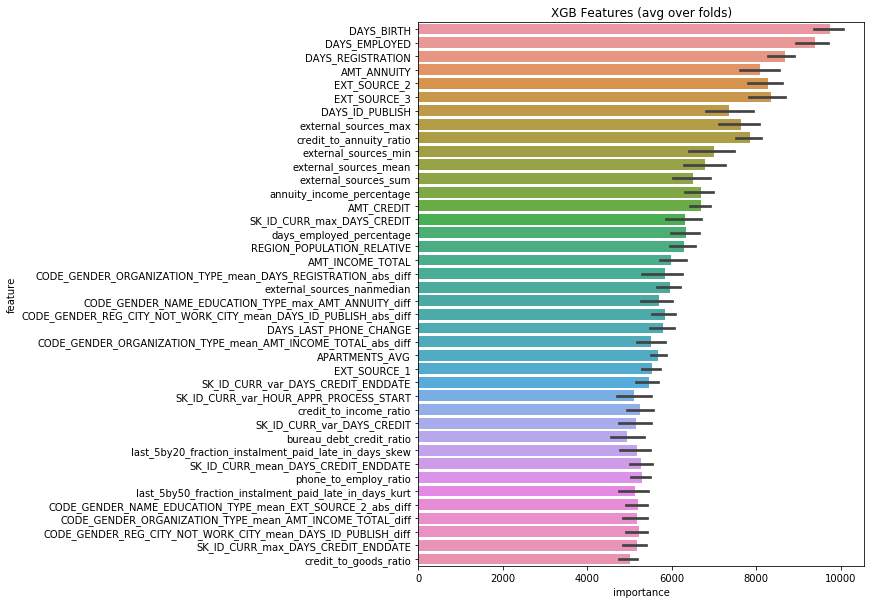

In [18]:
cols = feature_importance_df[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:40].index
best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]
plt.figure(figsize=(8, 10))
sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
plt.title('XGB Features (avg over folds)')
plt.tight_layout
plt.show()

In [19]:
feature_importance_df.to_csv('feature_importance_xgb1030features03.csv', index=False)

In [ ]:
############################################
################  Again Again ##############
############################################

In [5]:
print("Starting XGBOOST. Train shape: {}, test shape: {}".format(train_df.shape, test_df.shape))
folds = KFold(n_splits= 5, shuffle=True, random_state=1001)
    # Create arrays and dataframes to store results
oof_preds = np.zeros(train_df.shape[0])
sub_preds = np.zeros(test_df.shape[0])
feature_importance_df = pd.DataFrame()

feats = [f for f in train_df.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
dtest=xgb.DMatrix(test_df[feats])
    
for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df['TARGET'])):
    dtrain = xgb.DMatrix(train_df[feats].iloc[train_idx],train_df['TARGET'].iloc[train_idx])
    dvalid = xgb.DMatrix(train_df[feats].iloc[valid_idx], train_df['TARGET'].iloc[valid_idx])
    valid_y=train_df['TARGET'].iloc[valid_idx]

       # xgb
    params = {'eval_metric': 'auc',
              'objective': 'binary:logistic',
              'booster':'gbtree',
              'tree_method': 'gpu_hist',
              'nthread' : 4,
              'eta' : 0.01,
                'max_leaves': 50,
              'max_depth' : 13,
              'max_bin': 297,
              'min_child_weight' : 9.7846,
              'subsample' : 0.7896,
              'colsample_bytree' : 0.6418,
              'colsample_bylevel' : 1,
              'alpha' : 0.0025,
              'lambda' : 0.0025,
              'scale_pos_weight': 6.0546}
    watchlist = [(dtrain, 'train'), (dvalid, 'valid')]
        
    model=xgb.train(params, dtrain, 2000, watchlist, maximize=True, early_stopping_rounds = 100, verbose_eval=100)
    oof_preds[valid_idx] = model.predict(dvalid, ntree_limit=model.best_ntree_limit)
    sub_preds += model.predict(dtest,ntree_limit=model.best_ntree_limit) / folds.n_splits

    fold_importance_df = pd.DataFrame()
    fold_importance_df = pd.DataFrame(model.get_fscore().items(), columns=['feature','importance']).sort_values('importance', ascending=False)
    fold_importance_df["fold"] = n_fold + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(valid_y, oof_preds[valid_idx])))
    del model, dtrain, dvalid, valid_y

print('Full AUC score %.6f' % roc_auc_score(train_df['TARGET'], oof_preds))
    # Write submission file and plot feature importance
test_df['TARGET'] = sub_preds
test_df[['SK_ID_CURR', 'TARGET']].to_csv('xgb_504feature05.csv', index= False)

Starting XGBOOST. Train shape: (307511, 504), test shape: (48744, 504)
[0]	train-auc:0.729698	valid-auc:0.724399
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 100 rounds.
[100]	train-auc:0.76852	valid-auc:0.756099
[200]	train-auc:0.782004	valid-auc:0.763534
[300]	train-auc:0.794912	valid-auc:0.770405
[400]	train-auc:0.805838	valid-auc:0.775402
[500]	train-auc:0.814976	valid-auc:0.779007
[600]	train-auc:0.822896	valid-auc:0.781622
[700]	train-auc:0.830148	valid-auc:0.783839
[800]	train-auc:0.837012	valid-auc:0.785679
[900]	train-auc:0.843294	valid-auc:0.787019
[1000]	train-auc:0.849471	valid-auc:0.788096
[1100]	train-auc:0.855241	valid-auc:0.788959
[1200]	train-auc:0.860685	valid-auc:0.789747
[1300]	train-auc:0.866043	valid-auc:0.790361
[1400]	train-auc:0.871086	valid-auc:0.790727
[1500]	train-auc:0.87593	valid-auc:0.791081
[1600]	train-auc:0.880576	valid-auc:0.791532
[1700]	train-auc:0.885061	valid-au

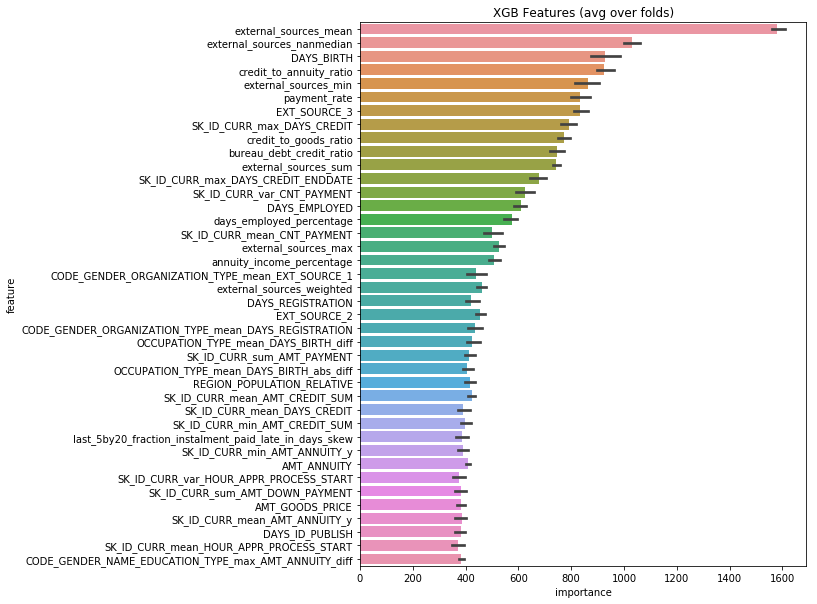

In [6]:
cols = feature_importance_df[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:40].index
best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]
plt.figure(figsize=(8, 10))
sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
plt.title('XGB Features (avg over folds)')
plt.tight_layout
plt.show()

In [7]:
feature_importance_df.to_csv('feature_importance_xgb504features05.csv', index=False)

In [ ]:
#################################################
################  xgb504features06 ##############
#################################################

In [8]:
print("Starting XGBOOST. Train shape: {}, test shape: {}".format(train_df.shape, test_df.shape))
folds = KFold(n_splits= 5, shuffle=True, random_state=1001)
    # Create arrays and dataframes to store results
oof_preds = np.zeros(train_df.shape[0])
sub_preds = np.zeros(test_df.shape[0])
feature_importance_df = pd.DataFrame()

feats = [f for f in train_df.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
dtest=xgb.DMatrix(test_df[feats])
    
for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df['TARGET'])):
    dtrain = xgb.DMatrix(train_df[feats].iloc[train_idx],train_df['TARGET'].iloc[train_idx])
    dvalid = xgb.DMatrix(train_df[feats].iloc[valid_idx], train_df['TARGET'].iloc[valid_idx])
    valid_y=train_df['TARGET'].iloc[valid_idx]

       # xgb
    params = {'eval_metric': 'auc',
              'objective': 'binary:logistic',
              'booster':'gbtree',
              'tree_method': 'gpu_hist',
              'nthread' : 4,
              'eta' : 0.01,
                'max_leaves': 50,
              'max_depth' : 13,
              'max_bin': 297,
              'min_child_weight' : 9.7846,
              'subsample' : 0.7896,
              'colsample_bytree' : 0.6418,
              'colsample_bylevel' : 1,
              'alpha' : 0.0025,
              'lambda' : 0.0025,
              'scale_pos_weight': 6.0546}
    watchlist = [(dtrain, 'train'), (dvalid, 'valid')]
        
    model=xgb.train(params, dtrain, 5000, watchlist, maximize=True, early_stopping_rounds = 100, verbose_eval=100)
    oof_preds[valid_idx] = model.predict(dvalid, ntree_limit=model.best_ntree_limit)
    sub_preds += model.predict(dtest,ntree_limit=model.best_ntree_limit) / folds.n_splits

    fold_importance_df = pd.DataFrame()
    fold_importance_df = pd.DataFrame(model.get_fscore().items(), columns=['feature','importance']).sort_values('importance', ascending=False)
    fold_importance_df["fold"] = n_fold + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(valid_y, oof_preds[valid_idx])))
    del model, dtrain, dvalid, valid_y

print('Full AUC score %.6f' % roc_auc_score(train_df['TARGET'], oof_preds))
    # Write submission file and plot feature importance
test_df['TARGET'] = sub_preds
test_df[['SK_ID_CURR', 'TARGET']].to_csv('xgb_504feature06.csv', index= False)

Starting XGBOOST. Train shape: (307511, 504), test shape: (48744, 504)
[0]	train-auc:0.729698	valid-auc:0.724399
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 100 rounds.
[100]	train-auc:0.76852	valid-auc:0.756099
[200]	train-auc:0.782004	valid-auc:0.763534
[300]	train-auc:0.794912	valid-auc:0.770405
[400]	train-auc:0.805838	valid-auc:0.775402
[500]	train-auc:0.814976	valid-auc:0.779007
[600]	train-auc:0.822896	valid-auc:0.781622
[700]	train-auc:0.830148	valid-auc:0.783839
[800]	train-auc:0.837012	valid-auc:0.785679
[900]	train-auc:0.843294	valid-auc:0.787019
[1000]	train-auc:0.849471	valid-auc:0.788096
[1100]	train-auc:0.855241	valid-auc:0.788959
[1200]	train-auc:0.860685	valid-auc:0.789747
[1300]	train-auc:0.866043	valid-auc:0.790361
[1400]	train-auc:0.871086	valid-auc:0.790727
[1500]	train-auc:0.87593	valid-auc:0.791081
[1600]	train-auc:0.880576	valid-auc:0.791532
[1700]	train-auc:0.885061	valid-au

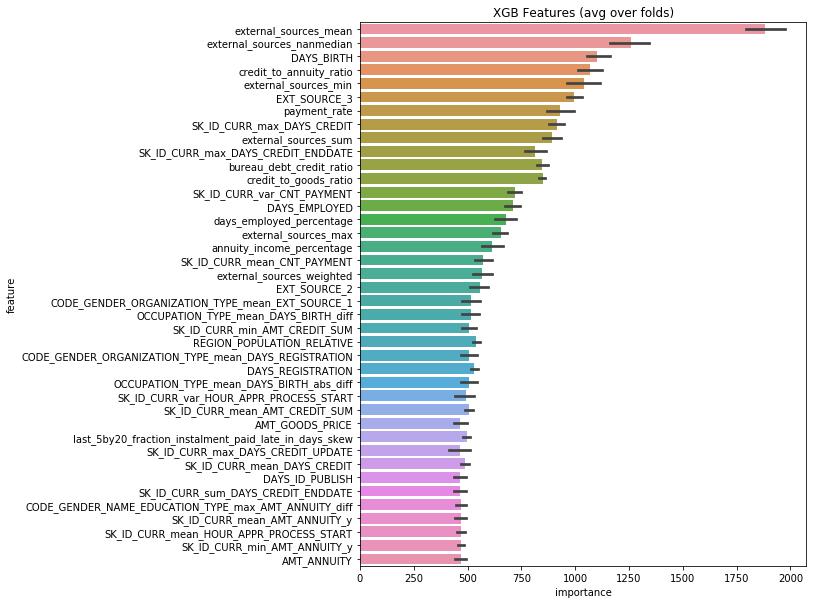

In [9]:
cols = feature_importance_df[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:40].index
best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]
plt.figure(figsize=(8, 10))
sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
plt.title('XGB Features (avg over folds)')
plt.tight_layout
plt.show()

In [10]:
feature_importance_df.to_csv('feature_importance_xgb504features06.csv', index=False)

In [ ]:
#################################################
################  xgb504features07 ##############
#################################################

In [8]:
print("Starting XGBOOST. Train shape: {}, test shape: {}".format(train_df.shape, test_df.shape))
folds = KFold(n_splits= 5, shuffle=True, random_state=1001)
    # Create arrays and dataframes to store results
oof_preds = np.zeros(train_df.shape[0])
sub_preds = np.zeros(test_df.shape[0])
feature_importance_df = pd.DataFrame()

feats = [f for f in train_df.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
dtest=xgb.DMatrix(test_df[feats])
    
for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df['TARGET'])):
    dtrain = xgb.DMatrix(train_df[feats].iloc[train_idx],train_df['TARGET'].iloc[train_idx])
    dvalid = xgb.DMatrix(train_df[feats].iloc[valid_idx], train_df['TARGET'].iloc[valid_idx])
    valid_y=train_df['TARGET'].iloc[valid_idx]

       # xgb
    params = {'eval_metric': 'auc',
              'objective': 'binary:logistic',
              'booster':'gbtree',
              'tree_method': 'gpu_hist',
              'nthread' : 4,
              'eta' : 0.01,
                'max_leaves': 50,
              'max_depth' : 7,
              'max_bin': 366,
              'min_child_weight' : 3.4711,
              'subsample' : 0.5600,
              'colsample_bytree' : 0.6031,
              'colsample_bylevel' : 1,
              'alpha' : 0.0002,
              'lambda' : 0.0006,
              'scale_pos_weight': 45.7581}
    watchlist = [(dtrain, 'train'), (dvalid, 'valid')]
        
    model=xgb.train(params, dtrain, 5000, watchlist, maximize=True, early_stopping_rounds = 100, verbose_eval=100)
    oof_preds[valid_idx] = model.predict(dvalid, ntree_limit=model.best_ntree_limit)
    sub_preds += model.predict(dtest,ntree_limit=model.best_ntree_limit) / folds.n_splits

    fold_importance_df = pd.DataFrame()
    fold_importance_df = pd.DataFrame(model.get_fscore().items(), columns=['feature','importance']).sort_values('importance', ascending=False)
    fold_importance_df["fold"] = n_fold + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(valid_y, oof_preds[valid_idx])))
    del model, dtrain, dvalid, valid_y

print('Full AUC score %.6f' % roc_auc_score(train_df['TARGET'], oof_preds))
    # Write submission file and plot feature importance
test_df['TARGET'] = sub_preds
test_df[['SK_ID_CURR', 'TARGET']].to_csv('xgb_504feature07.csv', index= False)

Starting XGBOOST. Train shape: (307511, 504), test shape: (48744, 504)
[0]	train-auc:0.726223	valid-auc:0.717234
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 100 rounds.
[100]	train-auc:0.773387	valid-auc:0.754667
[200]	train-auc:0.785516	valid-auc:0.760963
[300]	train-auc:0.79765	valid-auc:0.767048
[400]	train-auc:0.808897	valid-auc:0.771843
[500]	train-auc:0.818025	valid-auc:0.775079
[600]	train-auc:0.825848	valid-auc:0.777384
[700]	train-auc:0.832845	valid-auc:0.779049
[800]	train-auc:0.838971	valid-auc:0.780143
[900]	train-auc:0.844812	valid-auc:0.780854
[1000]	train-auc:0.850261	valid-auc:0.781302
[1100]	train-auc:0.855339	valid-auc:0.781471
[1200]	train-auc:0.860176	valid-auc:0.781765
[1300]	train-auc:0.865026	valid-auc:0.781977
[1400]	train-auc:0.869358	valid-auc:0.781917
Stopping. Best iteration:
[1310]	train-auc:0.865426	valid-auc:0.782047

Fold  1 AUC : 0.782047
[0]	train-auc:0.727852	valid

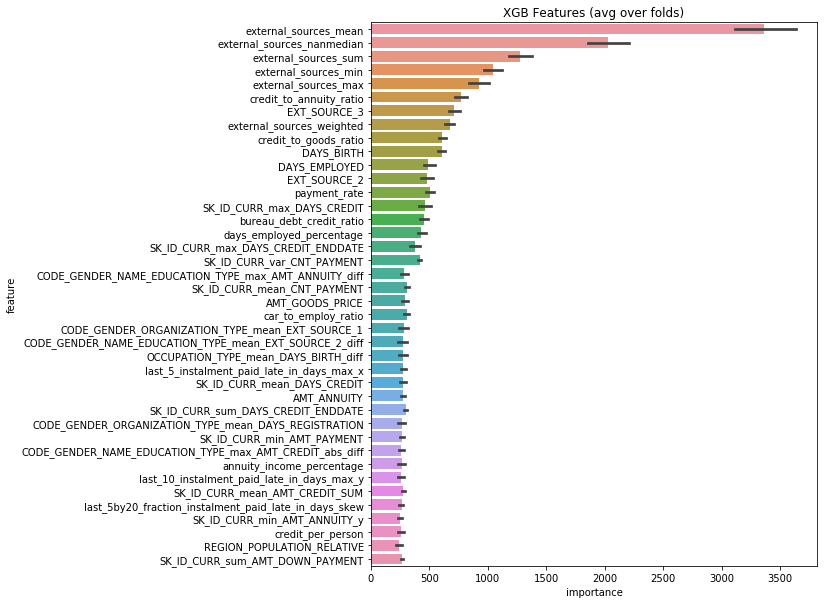

In [9]:
cols = feature_importance_df[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:40].index
best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]
plt.figure(figsize=(8, 10))
sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
plt.title('XGB Features (avg over folds)')
plt.tight_layout
plt.show()

In [10]:
feature_importance_df.to_csv('feature_importance_xgb504features07.csv', index=False)

In [ ]:
###############################################################
#################                                 #############
#############     xgb504features10 WITH 10 folds     ##########
################                                  #############
###############################################################

In [6]:
print("Starting XGBOOST. Train shape: {}, test shape: {}".format(train_df.shape, test_df.shape))
folds = KFold(n_splits= 10, shuffle=True, random_state=1001)
    # Create arrays and dataframes to store results
oof_preds = np.zeros(train_df.shape[0])
sub_preds = np.zeros(test_df.shape[0])
feature_importance_df = pd.DataFrame()

feats = [f for f in train_df.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
dtest=xgb.DMatrix(test_df[feats])
    
for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df['TARGET'])):
    dtrain = xgb.DMatrix(train_df[feats].iloc[train_idx],train_df['TARGET'].iloc[train_idx])
    dvalid = xgb.DMatrix(train_df[feats].iloc[valid_idx], train_df['TARGET'].iloc[valid_idx])
    valid_y=train_df['TARGET'].iloc[valid_idx]

       # xgb
    params = {'eval_metric': 'auc',
              'objective': 'binary:logistic',
              'booster':'gbtree',
              'tree_method': 'gpu_hist',
              'nthread' : 4,
              'eta' : 0.01,
                'max_leaves': 50,
              'max_depth' : 13,
              'max_bin': 297,
              'min_child_weight' : 9.7846,
              'subsample' : 0.7896,
              'colsample_bytree' : 0.6418,
              'colsample_bylevel' : 1,
              'alpha' : 0.0025,
              'lambda' : 0.0025,
              'scale_pos_weight': 6.0546}
    watchlist = [(dtrain, 'train'), (dvalid, 'valid')]
        
    model=xgb.train(params, dtrain, 5000, watchlist, maximize=True, early_stopping_rounds = 100, verbose_eval=100)
    oof_preds[valid_idx] = model.predict(dvalid, ntree_limit=model.best_ntree_limit)
    sub_preds += model.predict(dtest,ntree_limit=model.best_ntree_limit) / folds.n_splits

    fold_importance_df = pd.DataFrame()
    fold_importance_df = pd.DataFrame(model.get_fscore().items(), columns=['feature','importance']).sort_values('importance', ascending=False)
    fold_importance_df["fold"] = n_fold + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(valid_y, oof_preds[valid_idx])))
    del model, dtrain, dvalid, valid_y

print('Full AUC score %.6f' % roc_auc_score(train_df['TARGET'], oof_preds))
    # Write submission file and plot feature importance
test_df['TARGET'] = sub_preds
test_df[['SK_ID_CURR', 'TARGET']].to_csv('xgb_504feature10.csv', index= False)

Starting XGBOOST. Train shape: (307511, 504), test shape: (48744, 504)
[0]	train-auc:0.729173	valid-auc:0.721874
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 100 rounds.
[100]	train-auc:0.767193	valid-auc:0.754067
[200]	train-auc:0.780483	valid-auc:0.762251
[300]	train-auc:0.79284	valid-auc:0.769211
[400]	train-auc:0.803269	valid-auc:0.77386
[500]	train-auc:0.811961	valid-auc:0.777527
[600]	train-auc:0.819635	valid-auc:0.780608
[700]	train-auc:0.82642	valid-auc:0.782962
[800]	train-auc:0.832591	valid-auc:0.784816
[900]	train-auc:0.83865	valid-auc:0.786549
[1000]	train-auc:0.844306	valid-auc:0.787718
[1100]	train-auc:0.84964	valid-auc:0.788572
[1200]	train-auc:0.854839	valid-auc:0.789353
[1300]	train-auc:0.859894	valid-auc:0.789983
[1400]	train-auc:0.864693	valid-auc:0.790542
[1500]	train-auc:0.869155	valid-auc:0.790914
[1600]	train-auc:0.873412	valid-auc:0.791175
[1700]	train-auc:0.877812	valid-auc:0

Will train until valid-auc hasn't improved in 100 rounds.
[100]	train-auc:0.767264	valid-auc:0.753153
[200]	train-auc:0.780342	valid-auc:0.761322
[300]	train-auc:0.793037	valid-auc:0.768331
[400]	train-auc:0.80353	valid-auc:0.773153
[500]	train-auc:0.81225	valid-auc:0.776362
[600]	train-auc:0.819976	valid-auc:0.778716
[700]	train-auc:0.826787	valid-auc:0.78048
[800]	train-auc:0.833153	valid-auc:0.781907
[900]	train-auc:0.839126	valid-auc:0.782902
[1000]	train-auc:0.844696	valid-auc:0.783738
[1100]	train-auc:0.850103	valid-auc:0.784342
[1200]	train-auc:0.855214	valid-auc:0.78494
[1300]	train-auc:0.860241	valid-auc:0.785359
[1400]	train-auc:0.865065	valid-auc:0.785755
[1500]	train-auc:0.869555	valid-auc:0.785995
[1600]	train-auc:0.873865	valid-auc:0.786275
[1700]	train-auc:0.877944	valid-auc:0.786563
[1800]	train-auc:0.881999	valid-auc:0.786735
[1900]	train-auc:0.885923	valid-auc:0.786812
[2000]	train-auc:0.889663	valid-auc:0.786896
[2100]	train-auc:0.89318	valid-auc:0.786919
[2200]	trai

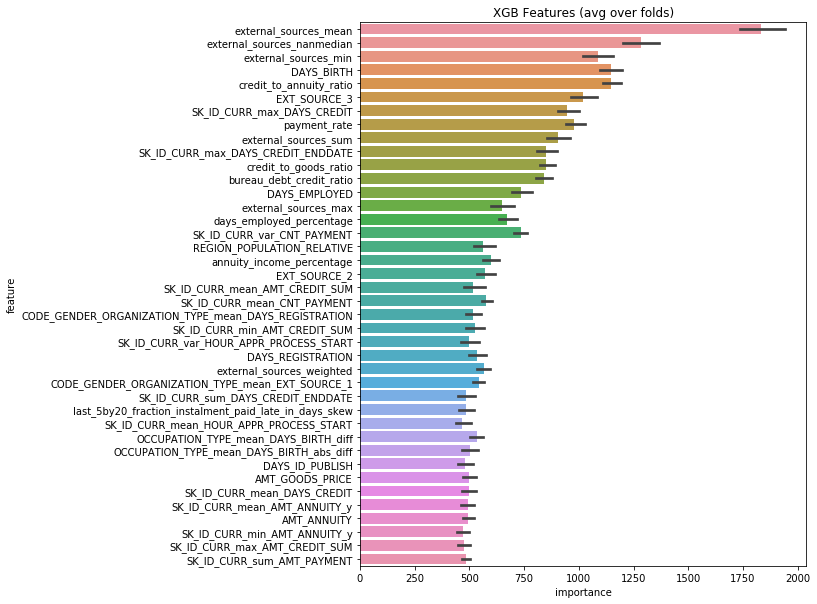

In [7]:
cols = feature_importance_df[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:40].index
best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]
plt.figure(figsize=(8, 10))
sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
plt.title('XGB Features (avg over folds)')
plt.tight_layout
plt.show()

In [8]:
feature_importance_df.to_csv('feature_importance_xgb504features10.csv', index=False)

In [ ]:
###############################################################
#################                                 #############
#############     xgb704features10 WITH 5 folds     ##########
################                                  #############
###############################################################

In [7]:
print("Starting XGBOOST. Train shape: {}, test shape: {}".format(train_df.shape, test_df.shape))
folds = KFold(n_splits= 5, shuffle=True, random_state=1001)
    # Create arrays and dataframes to store results
oof_preds = np.zeros(train_df.shape[0])
sub_preds = np.zeros(test_df.shape[0])
feature_importance_df = pd.DataFrame()

feats = [f for f in train_df.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
dtest=xgb.DMatrix(test_df[feats])
    
for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df['TARGET'])):
    dtrain = xgb.DMatrix(train_df[feats].iloc[train_idx],train_df['TARGET'].iloc[train_idx])
    dvalid = xgb.DMatrix(train_df[feats].iloc[valid_idx], train_df['TARGET'].iloc[valid_idx])
    valid_y=train_df['TARGET'].iloc[valid_idx]

       # xgb
    params = {'eval_metric': 'auc',
              'objective': 'binary:logistic',
              'booster':'gbtree',
              'tree_method': 'gpu_hist',
              'nthread' : 4,
              'eta' : 0.01,
                'max_leaves': 50,
              'max_depth' : 13,
              'max_bin': 297,
              'min_child_weight' : 9.7846,
              'subsample' : 0.7896,
              'colsample_bytree' : 0.6418,
              'colsample_bylevel' : 1,
              'alpha' : 0.0025,
              'lambda' : 0.0025,
              'scale_pos_weight': 1}
    watchlist = [(dtrain, 'train'), (dvalid, 'valid')]
        
    model=xgb.train(params, dtrain, 10000, watchlist, maximize=True, early_stopping_rounds = 100, verbose_eval=100)
    oof_preds[valid_idx] = model.predict(dvalid, ntree_limit=model.best_ntree_limit)
    sub_preds += model.predict(dtest,ntree_limit=model.best_ntree_limit) / folds.n_splits

    fold_importance_df = pd.DataFrame()
    fold_importance_df = pd.DataFrame(model.get_fscore().items(), columns=['feature','importance']).sort_values('importance', ascending=False)
    fold_importance_df["fold"] = n_fold + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(valid_y, oof_preds[valid_idx])))
    del model, dtrain, dvalid, valid_y

print('Full AUC score %.6f' % roc_auc_score(train_df['TARGET'], oof_preds))
    # Write submission file and plot feature importance
test_df['TARGET'] = sub_preds
test_df[['SK_ID_CURR', 'TARGET']].to_csv('xgb_704feature11.csv', index= False)

Starting XGBOOST. Train shape: (307511, 704), test shape: (48744, 704)
[0]	train-auc:0.732971	valid-auc:0.729203
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 100 rounds.
[100]	train-auc:0.761676	valid-auc:0.750737
[200]	train-auc:0.770662	valid-auc:0.7561
[300]	train-auc:0.781008	valid-auc:0.761852
[400]	train-auc:0.792637	valid-auc:0.767958
[500]	train-auc:0.803585	valid-auc:0.773718
[600]	train-auc:0.812933	valid-auc:0.777836
[700]	train-auc:0.821077	valid-auc:0.78116
[800]	train-auc:0.828402	valid-auc:0.783584
[900]	train-auc:0.835245	valid-auc:0.78561
[1000]	train-auc:0.841458	valid-auc:0.787049
[1100]	train-auc:0.847475	valid-auc:0.788245
[1200]	train-auc:0.853227	valid-auc:0.789135
[1300]	train-auc:0.85851	valid-auc:0.789855
[1400]	train-auc:0.863783	valid-auc:0.790661
[1500]	train-auc:0.86869	valid-auc:0.791102
[1600]	train-auc:0.873373	valid-auc:0.791552
[1700]	train-auc:0.877981	valid-auc:0.

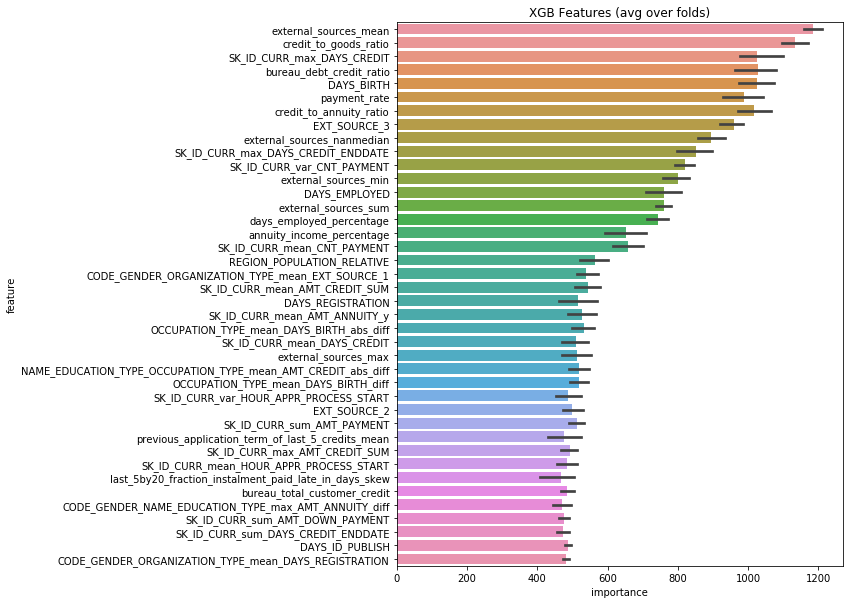

In [8]:
#Full AUC score 0.789282
cols = feature_importance_df[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:40].index
best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]
plt.figure(figsize=(8, 10))
sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
plt.title('XGB Features (avg over folds)')
plt.tight_layout
plt.show()

In [9]:
feature_importance_df.to_csv('feature_importance_xgb704features11.csv', index=False)

In [ ]:
###############################################################
#################                                 #############
#############     xgb504features13 WITH 10 folds     ##########
################                                  #############
###############################################################

In [6]:
print("Starting XGBOOST. Train shape: {}, test shape: {}".format(train_df.shape, test_df.shape))
folds = KFold(n_splits= 10, shuffle=True, random_state=1001)
    # Create arrays and dataframes to store results
oof_preds = np.zeros(train_df.shape[0])
sub_preds = np.zeros(test_df.shape[0])
feature_importance_df = pd.DataFrame()

feats = [f for f in train_df.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
dtest=xgb.DMatrix(test_df[feats])
    
for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df['TARGET'])):
    dtrain = xgb.DMatrix(train_df[feats].iloc[train_idx],train_df['TARGET'].iloc[train_idx])
    dvalid = xgb.DMatrix(train_df[feats].iloc[valid_idx], train_df['TARGET'].iloc[valid_idx])
    valid_y=train_df['TARGET'].iloc[valid_idx]

       # xgb
    params = {'eval_metric': 'auc',
              'objective': 'binary:logistic',
              'booster':'gbtree',
              'tree_method': 'gpu_hist',
              'nthread' : 4,
              'eta' : 0.01,
                'max_leaves': 50,
              'max_depth' : 13,
              'max_bin': 297,
              'min_child_weight' : 9.7846,
              'subsample' : 0.7896,
              'colsample_bytree' : 0.6418,
              'colsample_bylevel' : 1,
              'alpha' : 0.0025,
              'lambda' : 0.0025,
              'scale_pos_weight': 1}
    watchlist = [(dtrain, 'train'), (dvalid, 'valid')]
        
    model=xgb.train(params, dtrain, 10000, watchlist, maximize=True, early_stopping_rounds = 100, verbose_eval=100)
    oof_preds[valid_idx] = model.predict(dvalid, ntree_limit=model.best_ntree_limit)
    sub_preds += model.predict(dtest,ntree_limit=model.best_ntree_limit) / folds.n_splits

    fold_importance_df = pd.DataFrame()
    fold_importance_df = pd.DataFrame(model.get_fscore().items(), columns=['feature','importance']).sort_values('importance', ascending=False)
    fold_importance_df["fold"] = n_fold + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(valid_y, oof_preds[valid_idx])))
    del model, dtrain, dvalid, valid_y

print('Full AUC score %.6f' % roc_auc_score(train_df['TARGET'], oof_preds))
    # Write submission file and plot feature importance
test_df['TARGET'] = sub_preds
test_df[['SK_ID_CURR', 'TARGET']].to_csv('xgb_504feature13.csv', index= False)

Starting XGBOOST. Train shape: (307511, 504), test shape: (48744, 504)
[0]	train-auc:0.726713	valid-auc:0.724219
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 100 rounds.
[100]	train-auc:0.76025	valid-auc:0.749262
[200]	train-auc:0.768892	valid-auc:0.754355
[300]	train-auc:0.778934	valid-auc:0.760495
[400]	train-auc:0.790005	valid-auc:0.766407
[500]	train-auc:0.800424	valid-auc:0.771758
[600]	train-auc:0.809112	valid-auc:0.775466
[700]	train-auc:0.816729	valid-auc:0.778989
[800]	train-auc:0.823599	valid-auc:0.781678
[900]	train-auc:0.829925	valid-auc:0.783795
[1000]	train-auc:0.835801	valid-auc:0.785383
[1100]	train-auc:0.841446	valid-auc:0.786754
[1200]	train-auc:0.846847	valid-auc:0.787861
[1300]	train-auc:0.851957	valid-auc:0.788678
[1400]	train-auc:0.856712	valid-auc:0.78945
[1500]	train-auc:0.861355	valid-auc:0.79016
[1600]	train-auc:0.865709	valid-auc:0.7907
[1700]	train-auc:0.869998	valid-auc:0

[1800]	train-auc:0.874052	valid-auc:0.784064
[1900]	train-auc:0.87806	valid-auc:0.784365
[2000]	train-auc:0.881963	valid-auc:0.784749
[2100]	train-auc:0.885769	valid-auc:0.784991
[2200]	train-auc:0.889319	valid-auc:0.785234
[2300]	train-auc:0.892857	valid-auc:0.785261
[2400]	train-auc:0.89627	valid-auc:0.785419
[2500]	train-auc:0.899508	valid-auc:0.785662
[2600]	train-auc:0.902686	valid-auc:0.785679
[2700]	train-auc:0.905734	valid-auc:0.785809
[2800]	train-auc:0.908722	valid-auc:0.785907
[2900]	train-auc:0.91171	valid-auc:0.785957
Stopping. Best iteration:
[2835]	train-auc:0.909763	valid-auc:0.786028

Fold  6 AUC : 0.786028
[0]	train-auc:0.726815	valid-auc:0.719603
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 100 rounds.
[100]	train-auc:0.759991	valid-auc:0.74833
[200]	train-auc:0.7686	valid-auc:0.753429
[300]	train-auc:0.778633	valid-auc:0.759512
[400]	train-auc:0.789938	valid-auc:0.76583
[500]	trai

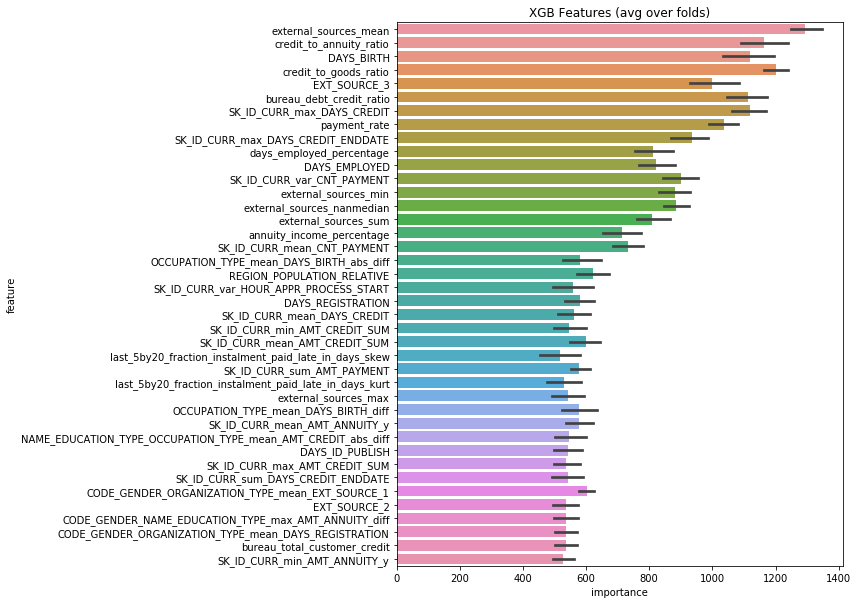

In [7]:
cols = feature_importance_df[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:40].index
best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]
plt.figure(figsize=(8, 10))
sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
plt.title('XGB Features (avg over folds)')
plt.tight_layout
plt.show()

In [8]:
feature_importance_df.to_csv('feature_importance_xgb504features13.csv', index=False)

In [ ]:
###############################################################
#################                              #############
#############     xgb1130features14 WITH 5 folds     ##########
################                                  #############
###############################################################

In [18]:
print("Starting XGBOOST. Train shape: {}, test shape: {}".format(train_df.shape, test_df.shape))
folds = KFold(n_splits= 5, shuffle=True, random_state=1001)
    # Create arrays and dataframes to store results
oof_preds = np.zeros(train_df.shape[0])
sub_preds = np.zeros(test_df.shape[0])
feature_importance_df = pd.DataFrame()

feats = [f for f in train_df.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
dtest=xgb.DMatrix(test_df[feats])
    
for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df['TARGET'])):
    dtrain = xgb.DMatrix(train_df[feats].iloc[train_idx],train_df['TARGET'].iloc[train_idx])
    dvalid = xgb.DMatrix(train_df[feats].iloc[valid_idx], train_df['TARGET'].iloc[valid_idx])
    valid_y=train_df['TARGET'].iloc[valid_idx]

       # xgb
    params = {'eval_metric': 'auc',
              'objective': 'binary:logistic',
              'booster':'gbtree',
              'tree_method': 'gpu_hist',
              'nthread' : 4,
              'eta' : 0.01,
                'max_leaves': 50,
              'max_depth' : 13,
              'max_bin': 297,
              'min_child_weight' : 9.7846,
              'subsample' : 0.7896,
              'colsample_bytree' : 0.6418,
              'colsample_bylevel' : 1,
              'alpha' : 0.01,
              'lambda' : 0.01,
              'scale_pos_weight': 1}
    watchlist = [(dtrain, 'train'), (dvalid, 'valid')]
        
    model=xgb.train(params, dtrain, 10000, watchlist, maximize=True, early_stopping_rounds = 100, verbose_eval=100)
    oof_preds[valid_idx] = model.predict(dvalid, ntree_limit=model.best_ntree_limit)
    sub_preds += model.predict(dtest,ntree_limit=model.best_ntree_limit) / folds.n_splits

    fold_importance_df = pd.DataFrame()
    fold_importance_df = pd.DataFrame(model.get_fscore().items(), columns=['feature','importance']).sort_values('importance', ascending=False)
    fold_importance_df["fold"] = n_fold + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(valid_y, oof_preds[valid_idx])))
    del model, dtrain, dvalid, valid_y

print('Full AUC score %.6f' % roc_auc_score(train_df['TARGET'], oof_preds))
    # Write submission file and plot feature importance
test_df['TARGET'] = sub_preds
test_df[['SK_ID_CURR', 'TARGET']].to_csv('xgb_1130feature14.csv', index= False)

Starting XGBOOST. Train shape: (307511, 1130), test shape: (48744, 1130)
[0]	train-auc:0.727408	valid-auc:0.717669
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 100 rounds.
[100]	train-auc:0.762115	valid-auc:0.751468
[200]	train-auc:0.770602	valid-auc:0.756149
[300]	train-auc:0.781299	valid-auc:0.761851
[400]	train-auc:0.792731	valid-auc:0.768068
[500]	train-auc:0.803719	valid-auc:0.773537
[600]	train-auc:0.813017	valid-auc:0.77763
[700]	train-auc:0.821201	valid-auc:0.78105
[800]	train-auc:0.828481	valid-auc:0.783482
[900]	train-auc:0.835076	valid-auc:0.785408
[1200]	train-auc:0.853455	valid-auc:0.789151
[1300]	train-auc:0.85875	valid-auc:0.789803
[1400]	train-auc:0.863921	valid-auc:0.790293
[1500]	train-auc:0.868872	valid-auc:0.790771
[1600]	train-auc:0.873648	valid-auc:0.791234
[1700]	train-auc:0.878164	valid-auc:0.791536
[1800]	train-auc:0.882692	valid-auc:0.791808
[1900]	train-auc:0.887001	valid-a

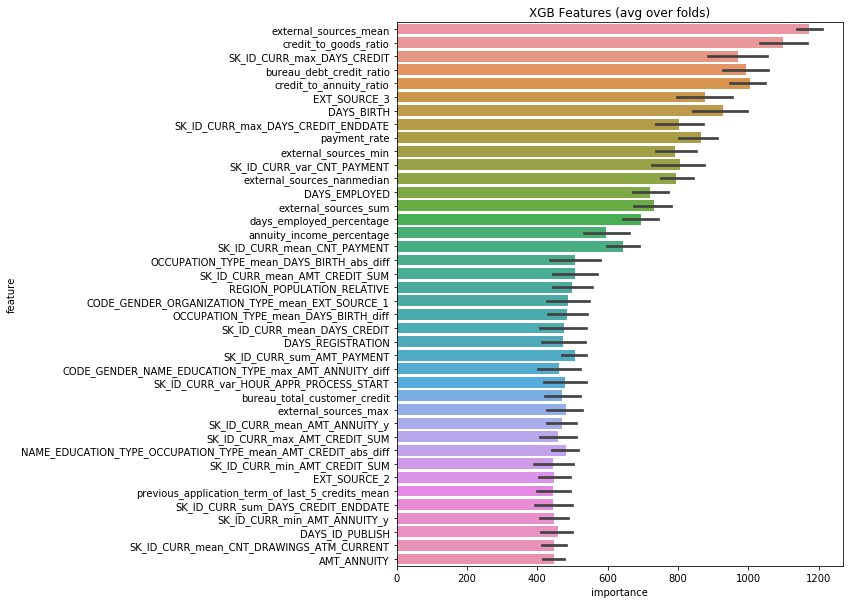

In [19]:
cols = feature_importance_df[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:40].index
best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]
plt.figure(figsize=(8, 10))
sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
plt.title('XGB Features (avg over folds)')
plt.tight_layout
plt.show()

In [20]:
feature_importance_df.to_csv('refresh_feature_importance_xgb1130features14.csv', index=False)

In [ ]:
###############################################################
#################                              #############
#############     xgb1130features15 WITH 5 folds     ##########
################                                  #############
###############################################################

In [22]:
print("Starting XGBOOST. Train shape: {}, test shape: {}".format(train_df.shape, test_df.shape))
folds = KFold(n_splits= 5, shuffle=True, random_state=1001)
    # Create arrays and dataframes to store results
oof_preds = np.zeros(train_df.shape[0])
sub_preds = np.zeros(test_df.shape[0])
feature_importance_df = pd.DataFrame()

feats = [f for f in train_df.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
dtest=xgb.DMatrix(test_df[feats])
    
for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df['TARGET'])):
    dtrain = xgb.DMatrix(train_df[feats].iloc[train_idx],train_df['TARGET'].iloc[train_idx])
    dvalid = xgb.DMatrix(train_df[feats].iloc[valid_idx], train_df['TARGET'].iloc[valid_idx])
    valid_y=train_df['TARGET'].iloc[valid_idx]

       # xgb
    params = {'eval_metric': 'auc',
              'objective': 'binary:logistic',
              'booster':'gbtree',
              'tree_method': 'gpu_hist',
              'nthread' : 4,
              'eta' : 0.01,
                'max_leaves': 50,
              'max_depth' : 13,
              'max_bin': 297,
              'min_child_weight' : 2,
              'subsample' : 0.7896,
              'colsample_bytree' : 0.6418,
              'colsample_bylevel' : 1,
              'alpha' : 0.0025,
              'lambda' : 0.0025,
              'scale_pos_weight': 1}
    watchlist = [(dtrain, 'train'), (dvalid, 'valid')]
        
    model=xgb.train(params, dtrain, 10000, watchlist, maximize=True, early_stopping_rounds = 100, verbose_eval=100)
    oof_preds[valid_idx] = model.predict(dvalid, ntree_limit=model.best_ntree_limit)
    sub_preds += model.predict(dtest,ntree_limit=model.best_ntree_limit) / folds.n_splits

    fold_importance_df = pd.DataFrame()
    fold_importance_df = pd.DataFrame(model.get_fscore().items(), columns=['feature','importance']).sort_values('importance', ascending=False)
    fold_importance_df["fold"] = n_fold + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(valid_y, oof_preds[valid_idx])))
    del model, dtrain, dvalid, valid_y

print('Full AUC score %.6f' % roc_auc_score(train_df['TARGET'], oof_preds))
    # Write submission file and plot feature importance
test_df['TARGET'] = sub_preds
test_df[['SK_ID_CURR', 'TARGET']].to_csv('xgb_1130feature15.csv', index= False)

Starting XGBOOST. Train shape: (307511, 1130), test shape: (48744, 1130)
[0]	train-auc:0.727403	valid-auc:0.71758
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 100 rounds.
[100]	train-auc:0.761898	valid-auc:0.750912
[200]	train-auc:0.770506	valid-auc:0.755549
[300]	train-auc:0.781736	valid-auc:0.761581
[400]	train-auc:0.793998	valid-auc:0.767799
[500]	train-auc:0.805819	valid-auc:0.773406
[600]	train-auc:0.815776	valid-auc:0.777599
[700]	train-auc:0.824798	valid-auc:0.780808
[800]	train-auc:0.832772	valid-auc:0.783246
[900]	train-auc:0.840084	valid-auc:0.784979
[1000]	train-auc:0.847045	valid-auc:0.786596
[1100]	train-auc:0.853375	valid-auc:0.787658
[1200]	train-auc:0.85939	valid-auc:0.788583
[1300]	train-auc:0.865178	valid-auc:0.789544
[1400]	train-auc:0.870427	valid-auc:0.790246
[1500]	train-auc:0.875479	valid-auc:0.790706
[1600]	train-auc:0.88037	valid-auc:0.791142
[1700]	train-auc:0.885034	valid-a

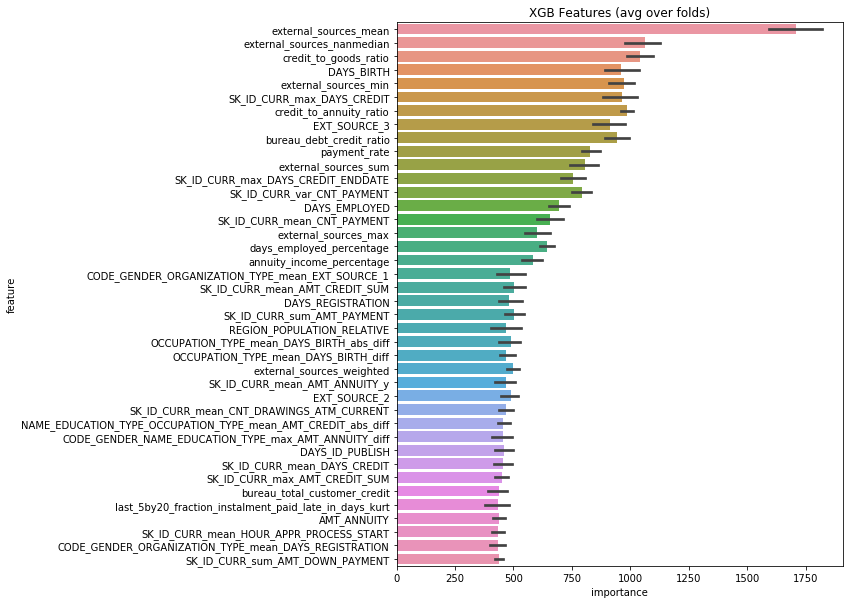

In [23]:
cols = feature_importance_df[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:40].index
best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]
plt.figure(figsize=(8, 10))
sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
plt.title('XGB Features (avg over folds)')
plt.tight_layout
plt.show()

In [24]:
feature_importance_df.to_csv('refresh_feature_importance_xgb1130features15.csv', index=False)

In [ ]:
###############################################################
#################                              #############
#############     xgb1130features16 WITH 5 folds     ##########
################                                  #############
###############################################################

In [17]:
print("Starting XGBOOST. Train shape: {}, test shape: {}".format(train_df.shape, test_df.shape))
folds = KFold(n_splits= 5, shuffle=True, random_state=1001)
    # Create arrays and dataframes to store results
oof_preds = np.zeros(train_df.shape[0])
sub_preds = np.zeros(test_df.shape[0])
feature_importance_df = pd.DataFrame()

feats = [f for f in train_df.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
dtest=xgb.DMatrix(test_df[feats])
    
for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df['TARGET'])):
    dtrain = xgb.DMatrix(train_df[feats].iloc[train_idx],train_df['TARGET'].iloc[train_idx])
    dvalid = xgb.DMatrix(train_df[feats].iloc[valid_idx], train_df['TARGET'].iloc[valid_idx])
    valid_y=train_df['TARGET'].iloc[valid_idx]

       # xgb
    params = {'eval_metric': 'auc',
              'objective': 'binary:logistic',
              'booster':'gbtree',
              'tree_method': 'gpu_hist',
              'nthread' : 4,
              'eta' : 0.01,
                'max_leaves': 50,
              'max_depth' : 13,
              'max_bin': 297,
              'min_child_weight' : 15,
              'subsample' : 0.7896,
              'colsample_bytree' : 0.6418,
              'colsample_bylevel' : 1,
              'alpha' : 0.0025,
              'lambda' : 0.0025,
              'scale_pos_weight': 1}
    watchlist = [(dtrain, 'train'), (dvalid, 'valid')]
        
    model=xgb.train(params, dtrain, 10000, watchlist, maximize=True, early_stopping_rounds = 100, verbose_eval=100)
    oof_preds[valid_idx] = model.predict(dvalid, ntree_limit=model.best_ntree_limit)
    sub_preds += model.predict(dtest,ntree_limit=model.best_ntree_limit) / folds.n_splits

    fold_importance_df = pd.DataFrame()
    fold_importance_df = pd.DataFrame(model.get_fscore().items(), columns=['feature','importance']).sort_values('importance', ascending=False)
    fold_importance_df["fold"] = n_fold + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(valid_y, oof_preds[valid_idx])))
    del model, dtrain, dvalid, valid_y

print('Full AUC score %.6f' % roc_auc_score(train_df['TARGET'], oof_preds))
    # Write submission file and plot feature importance
test_df['TARGET'] = sub_preds
test_df[['SK_ID_CURR', 'TARGET']].to_csv('xgb_1130feature16.csv', index= False)

Starting XGBOOST. Train shape: (307511, 1130), test shape: (48744, 1130)
[0]	train-auc:0.728135	valid-auc:0.717792
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 100 rounds.
[100]	train-auc:0.762188	valid-auc:0.75163
[200]	train-auc:0.770615	valid-auc:0.756374
[300]	train-auc:0.781295	valid-auc:0.762141
[400]	train-auc:0.792571	valid-auc:0.768468
[500]	train-auc:0.803371	valid-auc:0.774258
[600]	train-auc:0.812492	valid-auc:0.778381
[700]	train-auc:0.820547	valid-auc:0.781604
[800]	train-auc:0.827802	valid-auc:0.784077
[900]	train-auc:0.834441	valid-auc:0.786033
[1000]	train-auc:0.840731	valid-auc:0.787586
[1100]	train-auc:0.846669	valid-auc:0.788658
[1200]	train-auc:0.852399	valid-auc:0.789708
[1300]	train-auc:0.857747	valid-auc:0.790501
[1400]	train-auc:0.862957	valid-auc:0.791168
[1500]	train-auc:0.86788	valid-auc:0.791711
[1600]	train-auc:0.87254	valid-auc:0.79212
[1700]	train-auc:0.8771	valid-auc:

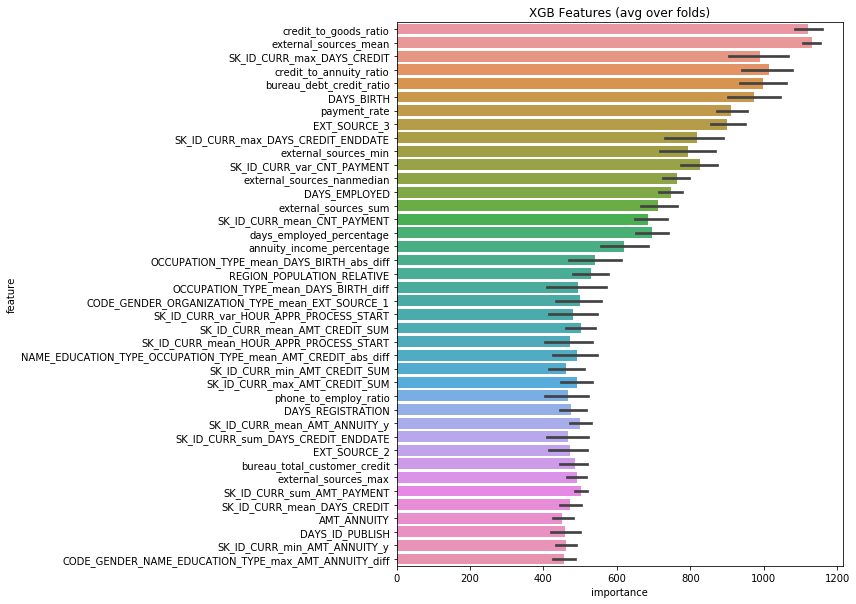

In [18]:
cols = feature_importance_df[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:40].index
best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]
plt.figure(figsize=(8, 10))
sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
plt.title('XGB Features (avg over folds)')
plt.tight_layout
plt.show()

In [19]:
feature_importance_df.to_csv('refresh_feature_importance_xgb1130features16.csv', index=False)

In [ ]:
#############################################################
################                                   ############
################                                    #############
###############   TURNING PARAMETERS  504features     ############
#############                                       #############
#############                                         ##########
################                                  #############
###############################################################

In [5]:
from bayes_opt import BayesianOptimization

In [6]:
feats = [f for f in train_df.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
X=train_df[feats]
y=train_df['TARGET']

In [7]:
del train_df
del test_df
gc.collect()

19

In [8]:
X

,external_sources_mean,external_sources_min,external_sources_nanmedian,external_sources_sum,EXT_SOURCE_2,external_sources_max,credit_to_annuity_ratio,payment_rate,EXT_SOURCE_3,external_sources_weighted,...,last_50_instalment_paid_over_amount_mean_y,SK_ID_CURR_max_AMT_DRAWINGS_ATM_CURRENT,10_period_trend_instalment_paid_over_amount,last_20_instalment_paid_over_amount_skew_y,NUM_INSTALMENT_VERSION_skew,last_50_NUM_INSTALMENT_VERSION_std_y,SK_ID_CURR_min_MONTHS_BALANCE_x,NAME_EDUCATION_TYPE_OCCUPATION_TYPE_REG_CITY_NOT_WORK_CITY_mean_ELEVATORS_AVG_diff,retirement_age,LANDAREA_MODE
0,0.161787,0.083037,0.139376,0.485361,0.262949,0.262949,16.461104,0.060749,0.139376,1.512423,...,0.000000,NaN,0.000000,0.000000,4.358899,0.229416,NaN,-0.070964,1,0.0377
1,0.466757,0.311267,0.466757,0.933513,0.622246,0.622246,36.234085,0.027598,NaN,NaN,...,0.000000,NaN,0.000000,0.000000,5.000000,0.200000,NaN,-0.022038,0,0.0128
2,0.642739,0.555912,0.642739,1.285479,0.555912,0.729567,20.000000,0.050000,0.729567,NaN,...,0.000000,NaN,0.000000,0.000000,1.732051,0.577350,NaN,NaN,0,NaN
3,0.650442,0.650442,0.650442,0.650442,0.650442,0.650442,10.532818,0.094941,NaN,NaN,...,0.000000,NaN,0.000000,0.000000,2.509457,0.341565,-6.0,NaN,0,NaN
4,0.322738,0.322738,0.322738,0.322738,0.322738,0.322738,23.461618,0.042623,NaN,NaN,...,-597.147300,NaN,0.000000,0.000000,1.830727,0.418452,NaN,NaN,0,NaN
5,0.487726,0.354225,0.487726,0.975451,0.354225,0.621226,17.824857,0.056101,0.621226,NaN,...,-342.461571,NaN,0.000000,-4.126947,5.916080,0.169031,NaN,NaN,0,NaN
6,0.663607,0.492060,0.724000,1.990821,0.724000,0.774761,37.789061,0.026463,0.492060,5.689763,...,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,NaN,NaN,1,NaN
7,0.627467,0.540654,0.627467,1.254934,0.714279,0.714279,36.363636,0.027500,0.540654,NaN,...,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,NaN,NaN,0,NaN
8,0.514935,0.205747,0.587334,1.544805,0.205747,0.751724,30.142344,0.033176,0.751724,4.798805,...,-4381.335000,180000.0,0.000000,-1.953039,0.347437,0.504672,-75.0,NaN,0,NaN
9,0.746644,0.746644,0.746644,0.746644,0.746644,0.746644,20.000000,0.050000,NaN,NaN,...,866.782500,NaN,324.367909,-4.080440,0.289699,0.771845,NaN,NaN,0,NaN


In [ ]:
def bayes_parameter_opt_xgb(X, y, init_round=5, opt_round=10, n_folds=5, random_seed=6, n_estimators=5000, learning_rate=0.01, output_process=True):
    # prepare data
    train_data = xgb.DMatrix(data=X, label=y)
    
    # parameters
    def xgb_eval(max_leaves, colsample_bytree, subsample, max_depth, reg_lambda, reg_alpha,  min_child_weight, scale_pos_weight,
                 max_bin):
        params = {'objective':'binary:logistic','booster': 'gbtree','tree_method': 'gpu_hist', 'nthread': 4, 'verbose': -1,\
                  'num_boost_round': n_estimators, 'learning_rate':learning_rate, \
                  'early_stopping_round':100, 'eval_metric':'auc','is_balance': False}
        params['max_bin']=int(round(max_bin))
        params["max_leaves"] = int(round(max_leaves))
        params['colsample_bytree'] = max(min(colsample_bytree, 1), 0)
        params['subsample'] = max(min(subsample, 1), 0)
        params['max_depth'] = int(round(max_depth))
        params['reg_lambda'] = max(reg_lambda, 0)
        params['reg_alpha'] = max(reg_alpha, 0)     
        params['min_child_weight'] = min_child_weight
        params['scale_pos_weight']= scale_pos_weight
        
        cv_result = xgb.cv(params, train_data, nfold=n_folds, seed=random_seed, stratified=True, verbose_eval =200, metrics='auc')
        #print cv_result
        return cv_result['train-auc-mean'].max()
    # range 
    xgbBO = BayesianOptimization(xgb_eval, {'max_leaves': (20, 50),
                                            'colsample_bytree': (0.4,0.9),
                                            'subsample': (0.4, 0.9),
                                            'max_depth': (4, 20),
                                            'reg_lambda': (0, 0.01),
                                            'reg_alpha': (0, 0.01),
                                            'min_child_weight': (2, 10),
                                            'scale_pos_weight':(0.99,100),
                                            'max_bin':(180,500)
                                           })
    # optimize
    xgbBO.maximize(init_points=init_round, n_iter=opt_round)
    
    # output optimization process
    #if output_process==True: xgbBO.points_to_csv("bayes_opt_result_xgb.csv")
    
    # return best parameters
    return xgbBO.res['max']['max_params']

opt_params = bayes_parameter_opt_xgb(X, y, init_round=5, opt_round=10, n_folds=5, random_seed=6, n_estimators=5000, learning_rate=0.01,output_process=True)

Initialization
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 Step |   Time |      Value |   colsample_bytree |   max_bin |   max_depth |   max_leaves |   min_child_weight |   reg_alpha |   reg_lambda |   scale_pos_weight |   subsample | 
[0]	train-auc:0.733322+0.000929368	test-auc:0.724556+0.00143017
[9]	train-auc:0.752708+0.000845374	test-auc:0.740124+0.00226175
    1 | 01m02s |    0.75271 |             0.8277 |  496.6765 |      7.8064 |      39.9573 |             7.0732 |      0.0010 |       0.0067 |            42.1006 |      0.7569 | 
[0]	train-auc:0.723513+0.000780214	test-auc:0.716654+0.00223216
[9]	train-auc:0.74634+0.000889727	test-auc:0.739106+0.00276261
    2 | 00m59s |    0.74634 |             0.7622 |  374.9264 |     18.6562 |      25.5701 |             6.4503 |      0.0022 |       0.0036 |            22.9205 |      0.4795 | 
[0]	train-auc:0.728

/home/chenyang.shi/anaconda2/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-3.44757892e-05]), 'nit': 4, 'funcalls': 47}
  " state: %s" % convergence_dict)
/home/chenyang.shi/anaconda2/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/chenyang.shi/anaconda2/lib/python2.7/site-packages/bayes_opt-0.3.0-py2.7.egg/bayes_opt/helpers.py:95: RuntimeWarning: divide by zero encountered in true_divide


    6 | 01m09s |    0.75673 |             0.4541 |  477.5570 |     14.2636 |      49.0374 |             4.8402 |      0.0047 |       0.0056 |            50.8793 |      0.6161 | 
[0]	train-auc:0.726913+0.00144779	test-auc:0.717172+0.00126021
[9]	train-auc:0.755028+0.00106018	test-auc:0.736046+0.00279284


/home/chenyang.shi/anaconda2/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-2.02443634e-05]), 'nit': 5, 'funcalls': 48}
  " state: %s" % convergence_dict)


    7 | 01m12s |    0.75503 |             0.6526 |  195.4406 |     19.1746 |      44.7195 |             3.7703 |      0.0075 |       0.0090 |            88.2142 |      0.8244 | 
[0]	train-auc:0.726832+0.000521712	test-auc:0.715517+0.00239014
[9]	train-auc:0.757836+0.000776456	test-auc:0.74066+0.00178499
    8 | 00m58s |    0.75784 |             0.6031 |  366.0901 |      7.4161 |      49.7477 |             3.4711 |      0.0002 |       0.0006 |            45.7581 |      0.5600 | 
[0]	train-auc:0.733987+0.00128406	test-auc:0.724522+0.00281522
[9]	train-auc:0.754038+0.000883126	test-auc:0.743442+0.00305547
    9 | 00m59s |    0.75404 |             0.8757 |  293.9796 |      7.8101 |      48.9330 |             3.9809 |      0.0088 |       0.0014 |             5.8355 |      0.5331 | 
[0]	train-auc:0.720209+0.000929932	test-auc:0.712136+0.0016509
[9]	train-auc:0.75225+0.0013522	test-auc:0.732554+0.00248894
   10 | 00m55s |    0.75225 |             0.6667 |  323.2061 |     18.5145 |      45.463

/home/chenyang.shi/anaconda2/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-8.80772934e-05]), 'nit': 5, 'funcalls': 57}
  " state: %s" % convergence_dict)


   11 | 01m06s |    0.75587 |             0.5674 |  240.5143 |     17.5077 |      46.5579 |             7.8779 |      0.0062 |       0.0047 |            33.7726 |      0.4948 | 
[0]	train-auc:0.723959+0.000820042	test-auc:0.713317+0.00392911


In [ ]:
#############################################################
################  TURNING PARAMETERS 1000 MMMMMYYYYY ########
#############################################################

In [19]:
def bayes_parameter_opt_xgb(X, y, init_round=5, opt_round=10, n_folds=5, random_seed=6, n_estimators=5000, learning_rate=0.01, output_process=True):
    # prepare data
    train_data = xgb.DMatrix(data=X, label=y)
    
    # parameters
    def xgb_eval(max_leaves, colsample_bytree, subsample, max_depth, reg_lambda, reg_alpha,  min_child_weight, scale_pos_weight,
                 max_bin):
        params = {'objective':'binary:logistic','booster': 'gbtree','tree_method': 'gpu_hist', 'nthread': 4, 'verbose': -1,\
                  'num_boost_round': n_estimators, 'learning_rate':learning_rate, \
                  'early_stopping_round':100, 'eval_metric':'auc','is_balance': False}
        params['max_bin']=int(round(max_bin))
        params["max_leaves"] = int(round(max_leaves))
        params['colsample_bytree'] = max(min(colsample_bytree, 1), 0)
        params['subsample'] = max(min(subsample, 1), 0)
        params['max_depth'] = int(round(max_depth))
        params['reg_lambda'] = max(reg_lambda, 0)
        params['reg_alpha'] = max(reg_alpha, 0)     
        params['min_child_weight'] = min_child_weight
        params['scale_pos_weight']= scale_pos_weight
        
        cv_result = xgb.cv(params, train_data, nfold=n_folds, seed=random_seed, stratified=True, verbose_eval =200, metrics='auc')
        #print cv_result
        return cv_result['train-auc-mean'].max()
    # range 
    xgbBO = BayesianOptimization(xgb_eval, {'max_leaves': (20, 50),
                                            'colsample_bytree': (0.5,1),
                                            'subsample': (0.5, 0.8),
                                            'max_depth': (3, 16),
                                            'reg_lambda': (0, 100),
                                            'reg_alpha': (0, 1),
                                            'min_child_weight': (1, 5),
                                            'scale_pos_weight':(0.99,100),
                                            'max_bin':(180,500)
                                           })
    # optimize
    xgbBO.maximize(init_points=init_round, n_iter=opt_round)
    
    # output optimization process
    if output_process==True: xgbBO.points_to_csv("bayes_opt_result_xgb.csv")
    
    # return best parameters
    return xgbBO.res['max']['max_params']

opt_params = bayes_parameter_opt_xgb(X, y, init_round=5, opt_round=10, n_folds=5, random_seed=6, n_estimators=5000, learning_rate=0.01,output_process=True)

Initialization
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 Step |   Time |      Value |   colsample_bytree |   max_bin |   max_depth |   max_leaves |   min_child_weight |   reg_alpha |   reg_lambda |   scale_pos_weight |   subsample | 
[0]	train-auc:0.730762+0.00108682	test-auc:0.7179+0.00281665
[9]	train-auc:0.760235+0.00097629	test-auc:0.735971+0.0034514
    1 | 07m08s |    0.76023 |             0.9962 |  450.7220 |      6.9513 |      49.0305 |             4.2558 |      0.6887 |      47.9436 |            65.7303 |      0.5935 | 
[0]	train-auc:0.741553+0.00196008	test-auc:0.71279+0.00374469
[9]	train-auc:0.78493+0.000775765	test-auc:0.742127+0.00327077
    2 | 06m21s |    0.78493 |             0.7566 |  443.6739 |      8.2487 |      40.2030 |             2.8439 |      0.2044 |      14.4403 |            42.1548 |      0.5618 | 
[0]	train-auc:0.734842+0.0

AttributeError: 'BayesianOptimization' object has no attribute 'points_to_csv'